#### OBJETIVO
- Prever se um passageiro foi transportado para uma dimensão alternativa durante a colisão da nave espacial Titanic

In [1]:
import numpy as np 
import pandas as pd 
import statsmodels.api as sm
import sweetviz as sv

from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB 
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

In [2]:
# pd.read_csv('sample_submission.csv')

In [3]:
test = pd.read_csv('test.csv')
test['CryoSleep'] = test['CryoSleep'].replace([False, True],[0,1])
test['VIP'] = test['VIP'].replace([False, True],[0,1])
test[['Id','Group']] = test.PassengerId.str.split("_",expand=True,)
test[['Deck','Num','Side']] = test.Cabin.str.split("/",expand=True,)
test.drop(['Name', 'Cabin'], inplace=True, axis=1)

test['Id'] =  test['Id'].astype(int)
test['Group'] =  test['Group'].astype(float)
test['Num'] =  test['Num'].astype(float)
test['CryoSleep'] =  test['CryoSleep'].astype(float)
test['VIP'] =  test['VIP'].astype(float)

test['HomePlanet'] = test['HomePlanet'].fillna('other')
test['CryoSleep'] = test['CryoSleep'].fillna(test['CryoSleep'].mean())
test['Destination'] = test['Destination'].fillna('other')
test['Age'] = test['Age'].fillna(test['Age'].mean())
test['VIP'] = test['VIP'].fillna(test['VIP'].mean())
test['RoomService'] = test['RoomService'].fillna(test['RoomService'].mean())
test['FoodCourt'] = test['FoodCourt'].fillna(test['FoodCourt'].mean())
test['ShoppingMall'] = test['ShoppingMall'].fillna(test['ShoppingMall'].mean())  
test['Spa'] = test['Spa'].fillna(test['Spa'].mean()) 
test['VRDeck'] = test['VRDeck'].fillna(test['VRDeck'].mean()) 
test['Deck'] = test['Deck'].fillna('other')
test['Num'] = test['Num'].fillna(test['Num'].mean())
test['Side'] = test['Side'].fillna('other')


In [4]:
train = pd.read_csv('train.csv')
train.loc[train['Name'] == 'Elaney Webstephrey']

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
156,0179_01,Earth,False,G/26/P,TRAPPIST-1e,19.0,False,1.0,219.0,673.0,2.0,11.0,Elaney Webstephrey,True
956,1018_01,Earth,True,G/150/P,TRAPPIST-1e,18.0,False,0.0,0.0,0.0,0.0,0.0,Elaney Webstephrey,True


In [5]:
# my_report = sv.analyze(train, target_feat='Transported')
# my_report.show_html()

## Transform Data

#### Replace and Split values

In [6]:
train['CryoSleep'] = train['CryoSleep'].replace([False, True],[0,1])
train['VIP'] = train['VIP'].replace([False, True],[0,1])
train[['Id','Group']] = train.PassengerId.str.split("_",expand=True,)
train[['Deck','Num','Side']] = train.Cabin.str.split("/",expand=True,)
train.drop(['Name', 'Cabin'], inplace=True, axis=1) 

#### Change Types

In [7]:
train['Id'] =  train['Id'].astype(int)
train['Group'] =  train['Group'].astype(float)
train['Num'] =  train['Num'].astype(float)
train['CryoSleep'] =  train['CryoSleep'].astype(float)
train['VIP'] =  train['VIP'].astype(float)

#### Replace null values

In [8]:
train['HomePlanet'] = train['HomePlanet'].fillna('other')
train['CryoSleep'] = train['CryoSleep'].fillna(train['CryoSleep'].mean())
train['Destination'] = train['Destination'].fillna('other')
train['Age'] = train['Age'].fillna(train['Age'].mean())
train['VIP'] = train['VIP'].fillna(train['VIP'].mean())
train['RoomService'] = train['RoomService'].fillna(train['RoomService'].mean())
train['FoodCourt'] = train['FoodCourt'].fillna(train['FoodCourt'].mean())
train['ShoppingMall'] = train['ShoppingMall'].fillna(train['ShoppingMall'].mean())
train['Spa'] = train['Spa'].fillna(train['Spa'].mean())
train['VRDeck'] = train['VRDeck'].fillna(train['VRDeck'].mean())
train['Deck'] = train['Deck'].fillna('other')
train['Num'] = train['Num'].fillna(train['Num'].mean())
train['Side'] = train['Side'].fillna('other')

In [9]:
train.head(1)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Id,Group,Deck,Num,Side
0,0001_01,Europa,0.0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,False,1,1.0,B,0.0,P


### Feature Eng

In [10]:
train['CryoSleep_HomePlanet'] = 0
train['CryoSleep_Destination'] = 0
train['CryoSleep_Deck'] = 0
train['CryoSleep_RoomService'] = 0
train['CryoSleep_RoomService<343'] = 0
train['CryoSleep_RoomService_Spa'] = 0
train['CryoSleep_VRDeck'] = 0

train.loc[(train['CryoSleep']==True) & (train['HomePlanet']== 'Europa'), 'CryoSleep_HomePlanet'] = 1
train.loc[(train['Destination']=='55 Cancri e') & (train['CryoSleep']==True), 'CryoSleep_Destination'] = 1
train.loc[(train['CryoSleep']==True) & (train['Deck']== 'G'), 'CryoSleep_Deck'] = 1
train.loc[(train['CryoSleep']==True) & (train['RoomService'] <= 2200), 'CryoSleep_RoomService'] = 1
train.loc[(train['CryoSleep']==True) & (train['RoomService'] <= 343), 'CryoSleep_RoomService<343'] = 1
train.loc[(train['CryoSleep']==True) & (train['RoomService'] <= 343) & (train['Spa'] <= 428), 'CryoSleep_RoomService_Spa'] = 1
train.loc[(train['CryoSleep']==True) & (train['VRDeck']<= 350), 'CryoSleep_VRDeck'] = 1

#### Remove outliers

In [ ]:
## Interquartile Range Method
q25, q75 = np.percentile(train['Spa'], 25), np.percentile(train['Spa'], 75)
iqr = q75 - q25
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
train = train.loc[(train['Spa'] <= upper) & (train['Spa'] >= lower)]
print(lower, upper, cut_off)

In [ ]:
## Interquartile Range Method
q25, q75 = np.percentile(train['VRDeck'], 25), np.percentile(train['VRDeck'], 75)
iqr = q75 - q25
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
train = train.loc[(train['VRDeck'] <= upper) & (train['VRDeck'] >= lower)]
print(lower, upper, cut_off)

In [ ]:
# Standard Deviation Method (normal)
data_mean, data_std = np.mean(train['Age']), np.std(train['Age'])
cut_off = data_std * 2
lower, upper = data_mean - cut_off, data_mean + cut_off
train = train.loc[(train['Age'] <= upper) & (train['Age'] >= 0)]
print(lower, upper, data_mean, data_std)

In [ ]:
# Standard Deviation Method (normal)
data_mean, data_std = np.mean(train['RoomService']), np.std(train['RoomService'])
cut_off = data_std * 2
lower, upper = data_mean - cut_off, data_mean + cut_off
train = train.loc[(train['RoomService'] <= upper) & (train['RoomService'] >= 0)]
print(lower, upper, data_mean, data_std)

#### Split values

In [11]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(
                                        train.drop(['Transported'], axis=1), 
                                        train[['PassengerId','Transported']], 
                                        test_size=0.60, random_state=42)

In [12]:
ytrain['Transported'] = ytrain['Transported'].replace([False, True],[0,1])
ytrain = ytrain['Transported']

In [13]:
ytest['Transported'] = ytest['Transported'].replace([False, True],[0,1])
ytest = ytest['Transported']

In [14]:
print(ytrain.count())
ytest.count()

3477


5216

In [15]:
xtrain = pd.get_dummies(xtrain, columns=['HomePlanet', 'Destination'
                                        , 'Deck', 'Side'], drop_first=True)

In [16]:
xtest = pd.get_dummies(xtest, columns=['HomePlanet', 'Destination'
                                        , 'Deck', 'Side'], drop_first=True)
xtest.head(1)

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Id,...,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_other,Side_S,Side_other
304,0337_02,0.0,19.0,0.0,417.0,349.0,634.0,3.0,1057.0,337,...,0,0,0,0,1,0,0,0,1,0


## Model

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
clf_dec = DecisionTreeClassifier(max_depth=4, min_samples_leaf=30, 
                                 min_samples_split=0.2, criterion='gini',splitter='best')
clf_dec.fit(xtrain, ytrain)
print(clf_dec.score(xtest, ytest))


0.758819018404908


In [18]:
from sklearn.metrics import classification_report
print(classification_report(ytrain, clf_dec.predict(xtrain)))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76      1725
           1       0.75      0.85      0.79      1752

    accuracy                           0.78      3477
   macro avg       0.78      0.78      0.78      3477
weighted avg       0.78      0.78      0.78      3477



In [19]:
pd.Series(
    clf_dec.feature_importances_,
    clf_dec.feature_names_in_
).sort_values().to_frame("Importance")

,Importance
PassengerId,0.000000
HomePlanet_Europa,0.000000
HomePlanet_Mars,0.000000
HomePlanet_other,0.000000
Destination_PSO J318.5-22,0.000000
Destination_TRAPPIST-1e,0.000000
Destination_other,0.000000
CryoSleep_VRDeck,0.000000
Deck_B,0.000000
Deck_D,0.000000


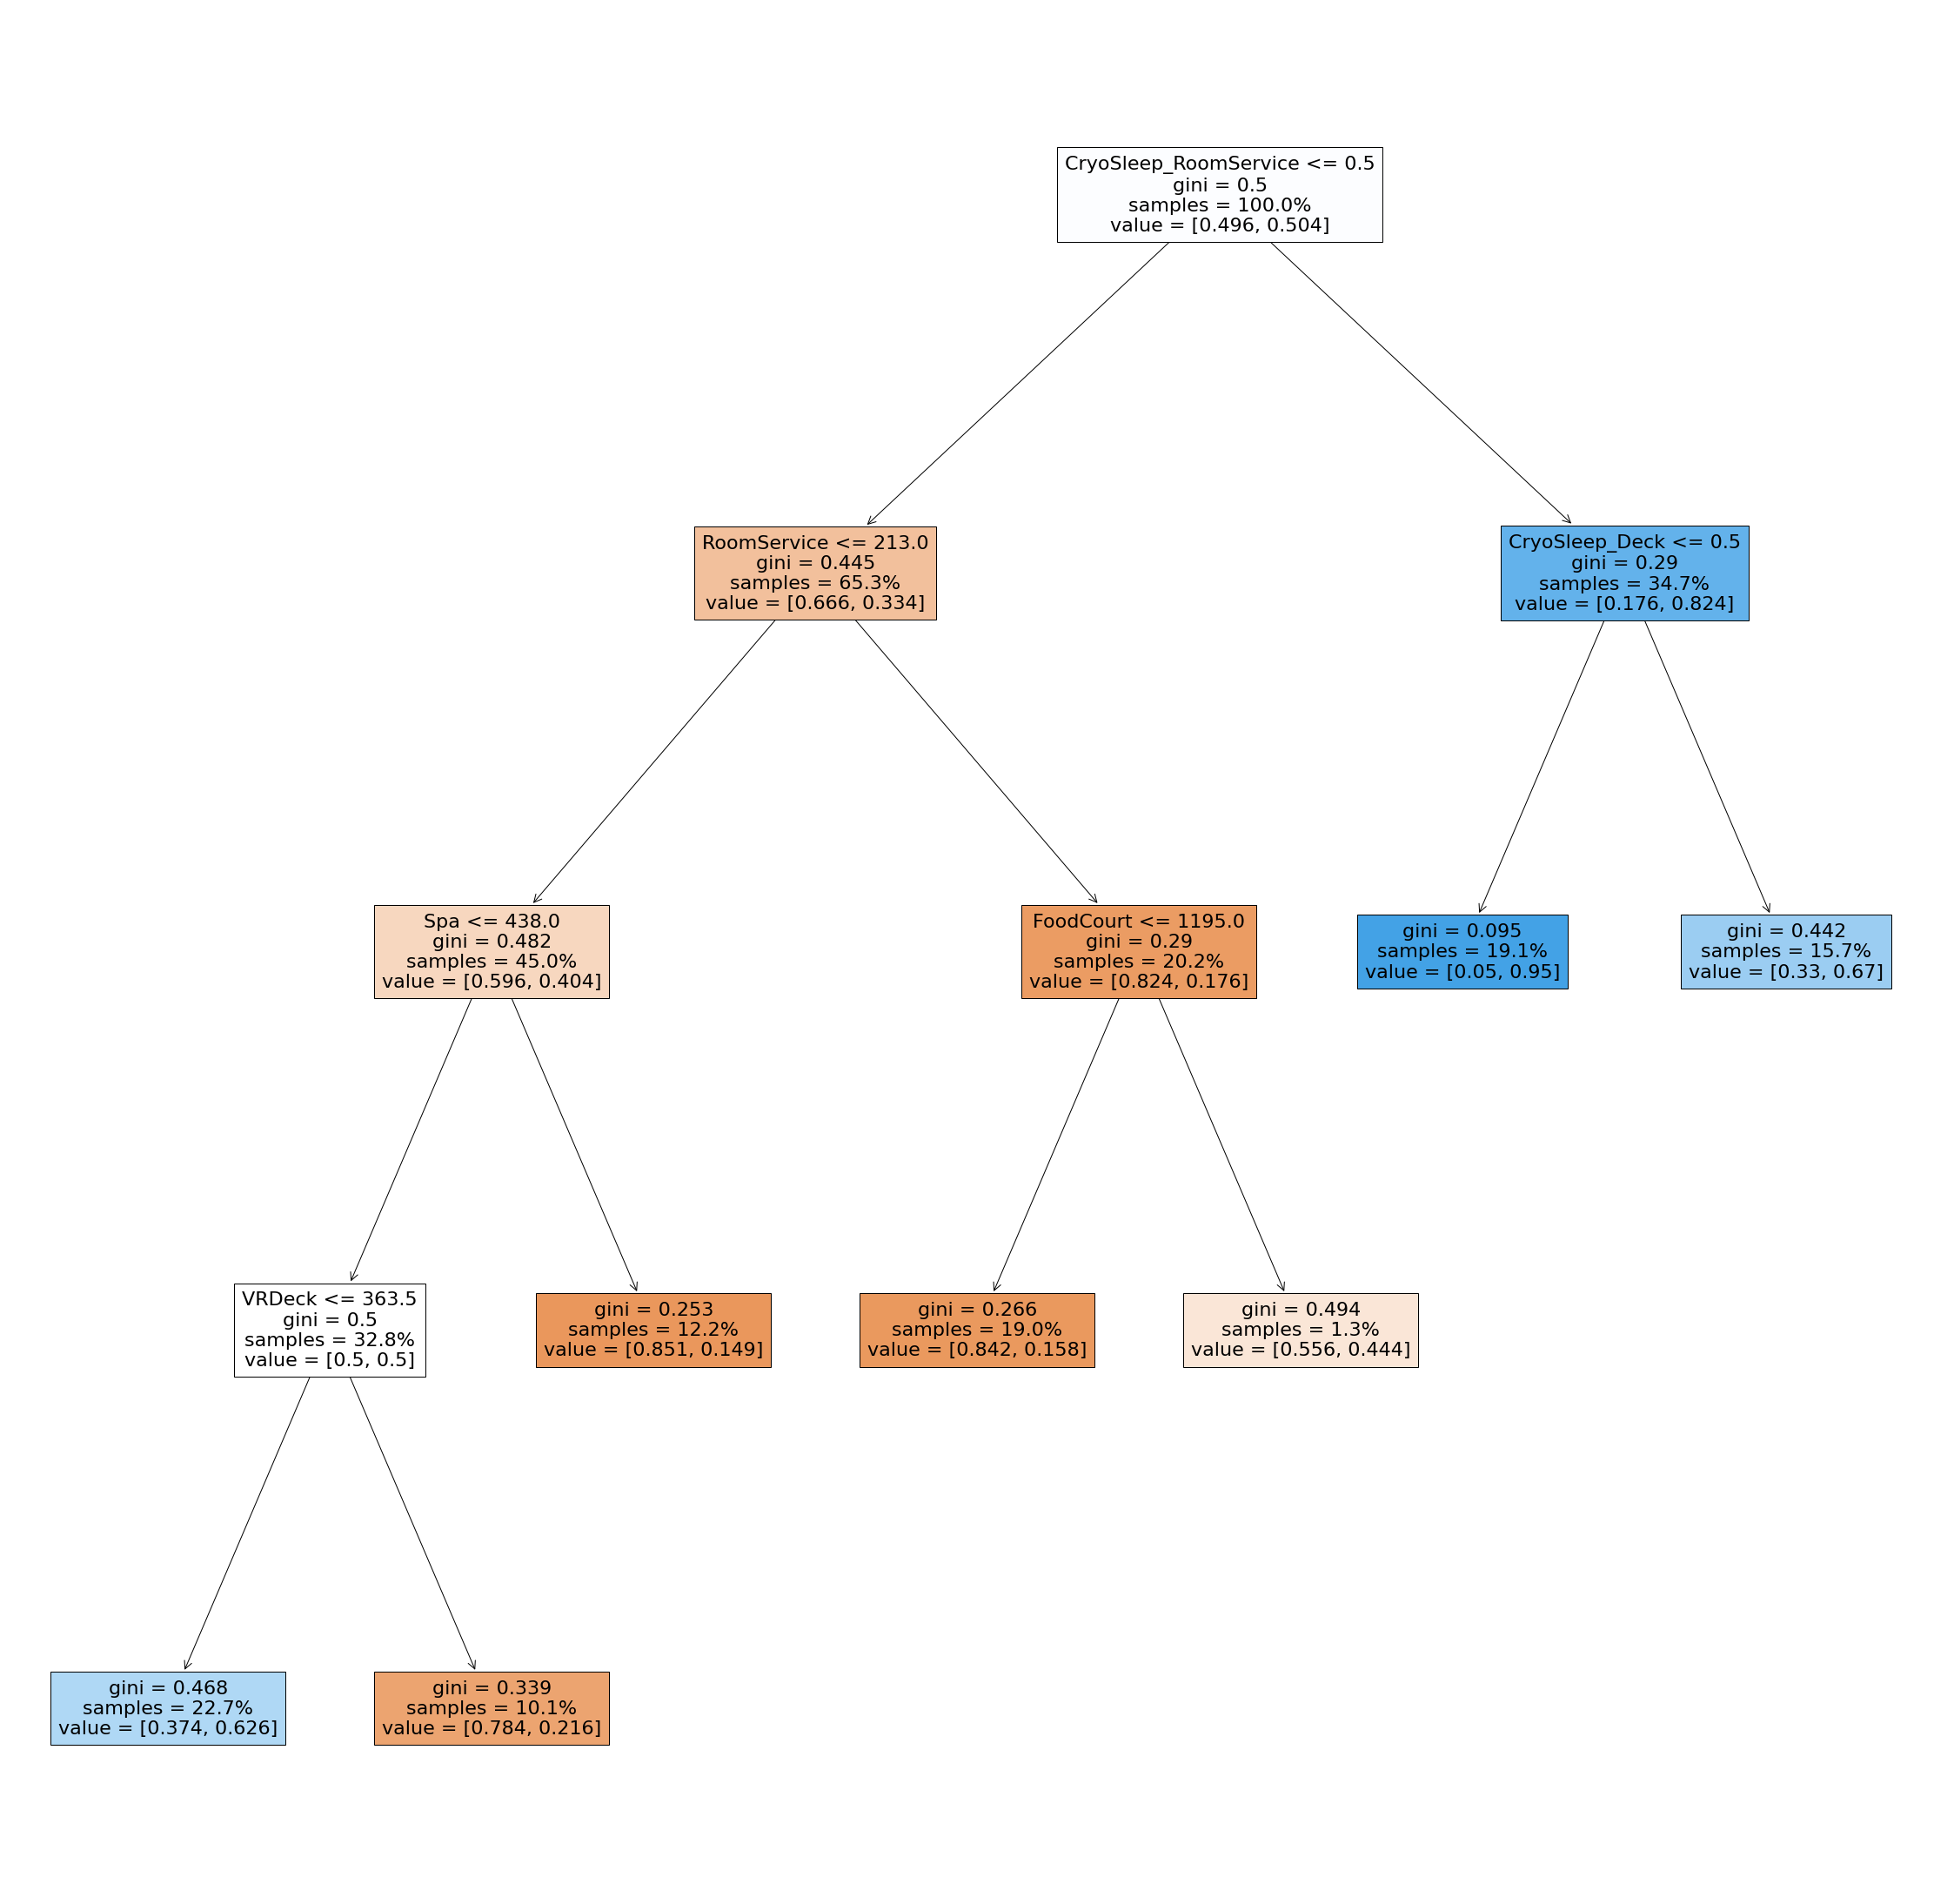

In [20]:
plt.figure(figsize=(40,40))
plot_tree(clf_dec, feature_names=xtrain.columns, proportion=True, filled=True)
plt.show()

In [21]:
clf_ln = LogisticRegression()
clf_ln.fit(xtrain, ytrain)
print(clf_ln.score(xtest, ytest))
print(f1_score(ytest, clf_ln.predict(xtest)))
print(classification_report(ytrain, clf_ln.predict(xtrain)))

0.7714723926380368
0.791389569478474
              precision    recall  f1-score   support

           0       0.83      0.69      0.76      1725
           1       0.74      0.86      0.80      1752

    accuracy                           0.78      3477
   macro avg       0.79      0.78      0.78      3477
weighted avg       0.79      0.78      0.78      3477



In [22]:
clf_gnb = GaussianNB()
clf_gnb.fit(xtrain, ytrain)
print(clf_gnb.score(xtest, ytest)) 
print(f1_score(ytest, clf_gnb.predict(xtest)))
print(classification_report(ytrain, clf_gnb.predict(xtrain)))

0.6681365030674846
0.7423723768417919
              precision    recall  f1-score   support

           0       0.87      0.38      0.53      1725
           1       0.61      0.95      0.74      1752

    accuracy                           0.66      3477
   macro avg       0.74      0.66      0.63      3477
weighted avg       0.74      0.66      0.63      3477



In [23]:
from sklearn.ensemble import RandomForestClassifier
clft = RandomForestClassifier(n_estimators=500)
clft = clft.fit(xtrain, ytrain)
print(clft.score(xtest, ytest))
print(f1_score(ytest, clft.predict(xtest)))
print(classification_report(ytrain, clft.predict(xtrain)))

0.7967791411042945
0.7932917316692668
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1725
           1       1.00      1.00      1.00      1752

    accuracy                           1.00      3477
   macro avg       1.00      1.00      1.00      3477
weighted avg       1.00      1.00      1.00      3477



In [38]:
from sklearn.ensemble import GradientBoostingClassifier
boost = GradientBoostingClassifier(n_estimators=500).fit(xtrain, ytrain)
print(boost.score(xtest, ytest))
print(f1_score(ytest, boost.predict(xtest)))
print(classification_report(ytrain, boost.predict(xtrain)))

0.7985046012269938
0.801135288552507
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1725
           1       0.93      0.93      0.93      1752

    accuracy                           0.93      3477
   macro avg       0.93      0.93      0.93      3477
weighted avg       0.93      0.93      0.93      3477



In [47]:
# from sklearn.ensemble import GradientBoostingClassifier
# boost = GradientBoostingClassifier(n_estimators=500, max_features=20, learning_rate=0.7).fit(xtrain, ytrain)
# print(boost.score(xtest, ytest))
# print(f1_score(ytest, boost.predict(xtest)))
# print(classification_report(ytrain, boost.predict(xtrain)))

0.7762653374233128
0.7773325701202062
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1725
           1       1.00      1.00      1.00      1752

    accuracy                           1.00      3477
   macro avg       1.00      1.00      1.00      3477
weighted avg       1.00      1.00      1.00      3477



In [41]:
# from xgboost import XGBClassifier
# boost1 = XGBClassifier()
# print(boost1.score(xtest, ytest))
# print(f1_score(ytest, boost1.predict(xtest)))
# print(classification_report(ytrain, boost1.predict(xtrain)))

In [ ]:
#to-do: 
#rede neural